In [2]:
#Assignment 2 Template

In [5]:
SEED                    = 156156   
GLM_SELECTION_THRESHOLD = 0.001   
MONO_THRESHOLD          = 6       
TRUE_POSITIVE_AMOUNT    = 0       
TRUE_NEGATIVE_AMOUNT    = 20000   
FALSE_POSITIVE_AMOUNT   = -20000
FALSE_NEGATIVE_AMOUNT   = -100000

In [1]:
import datetime                                               # for timestamp 
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python

# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 15.0.2+7-27, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ADMINI~1\AppData\Local\Temp\tmp7vjet62z
  JVM stdout: C:\Users\ADMINI~1\AppData\Local\Temp\tmp7vjet62z\h2o_Administrator_started_from_python.out
  JVM stderr: C:\Users\ADMINI~1\AppData\Local\Temp\tmp7vjet62z\h2o_Administrator_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,17 secs
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_Administrator_yufj91
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [3]:
tic = time.time()

In [6]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

In [7]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

In [9]:
##Making descriptive statistics
data[x_names + [y_name]].describe()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
count,160338.000000,160338.000000,160338.000000,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,160338.000000
mean,0.960328,0.928027,0.000617,1.518971e-16,3.813309e-16,-1.243723e-15,-6.991775e-15,2.016754e-15,4.592073e-16,9.179888e-16,0.096702
std,0.195189,0.258444,0.024841,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.295552
min,0.000000,0.000000,0.000000,-1.261924e+00,-3.479243e+00,-4.091747e+00,-2.153042e-01,-1.090958e+00,-9.782313e-02,-2.527547e+00,0.000000
25%,1.000000,1.000000,0.000000,-5.583656e-01,-2.753968e-01,2.443944e-01,-2.153042e-01,-5.359324e-01,-3.337777e-02,-4.251308e-01,0.000000
50%,1.000000,1.000000,0.000000,-2.505590e-01,1.792226e-01,2.443944e-01,-2.153042e-01,-2.584194e-01,-2.332984e-02,1.233255e-01,0.000000
75%,1.000000,1.000000,0.000000,2.771095e-01,4.280875e-01,2.443944e-01,-2.153042e-01,1.732675e-01,-7.738221e-03,6.717818e-01,0.000000
max,1.000000,1.000000,1.000000,5.150493e+01,2.027553e+02,2.443944e-01,1.687735e+01,4.084434e+01,3.055430e+02,3.871110e+00,1.000000


In [10]:
##Pearson Correlation Coefficient
corr = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']
corr

,Pearson Correlation Coefficient
term_360,0.052448
conforming,0.074543
debt_to_income_ratio_missing,0.008857
loan_amount_std,-0.123545
loan_to_value_ratio_std,0.111540
no_intro_rate_period_std,0.018108
intro_rate_period_std,-0.031716
property_value_std,-0.137319
income_std,-0.007911
debt_to_income_ratio_std,0.128645


In [ ]:
##It looks property_value_std and loan_amount_std is mostly correlated to our object, then make visitulation by plot the pearson correlation

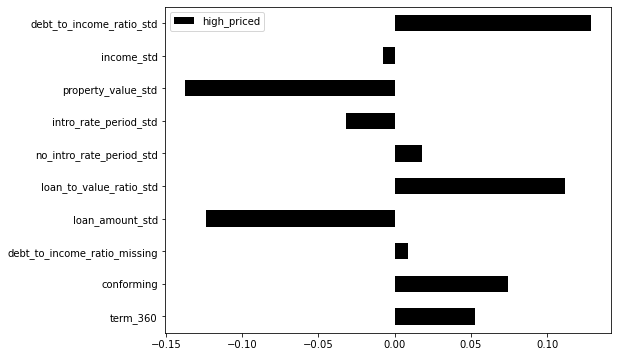

In [11]:
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')

In [ ]:
#Train Elastic Net Logistic GLM for Initial Feature Selection

In [ ]:
#Split data into train and validation partitions

In [15]:
np.random.seed(SEED) 

split_ratio = 0.75 #75%/25%

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 120039, columns = 23
Validation data rows = 40299, columns = 23


In [ ]:
##Train penalized GLM

In [20]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.01, 0.25, 0.5, 0.99]  # always keep some L2

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

In [34]:
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

best_glm = glm_grid(x_names, y_name, h2o.H2OFrame(train),
                            h2o.H2OFrame(valid), SEED)

# output results
print('Best penalized GLM AUC: %.2f' % 
      best_glm.auc(valid=True))

# print selected coefficients
print('Best penalized GLM coefficients:')
for c_name, c_val in sorted(best_glm.coef().items(), key=operator.itemgetter(1)):
    if abs(c_val) > GLM_SELECTION_THRESHOLD:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

Best penalized GLM AUC: 0.76
Best penalized GLM coefficients:
Intercept:                -2.4843927383955036
property_value_std:       -0.7736692795182066
term_360:                 0.021071520548018762
loan_to_value_ratio_std:  0.18911772446993286
debt_to_income_ratio_std: 0.29275256653568194


In [36]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7628.


In [88]:
best_glm_submit = best_glm.predict(h2o.H2OFrame(test)).as_data_frame() 
best_glm_submit.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_submit.columns = ['phat']
best_glm_submit.to_csv('ph_best_glm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

In [39]:
#Model Details 
##Display the GLM information
best_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_a49fc2e25c28533d5a54c6cc793f40b6.hex_model_python_1623033002240_37_model_4


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.99, lambda = 0.008384 )","nlambda = 100, lambda.max = 0.04077, lambda.min = 0.008384, lambda...",10,4,29,Key_Frame__upload_a49fc2e25c28533d5a54c6cc793f40b6.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.08273063472985832
RMSE: 0.28762933565590687
LogLoss: 0.2914783710223145
Null degrees of freedom: 120038
Residual degrees of freedom: 120034
Null deviance: 76424.83492474812
Residual deviance: 69980.55411228364
AIC: 69990.55411228364
AUC: 0.7527342614430345
AUCPR: 0.220577659824834
Gini: 0.5054685228860689

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12720379139649113: 


,,0,1,Error,Rate
0,0,85412.0,22989.0,0.2121,(22989.0/108401.0)
1,1,5257.0,6381.0,0.4517,(5257.0/11638.0)
2,Total,90669.0,29370.0,0.2353,(28246.0/120039.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.127204,0.311208,147.0
1,max f2,0.103030,0.464047,199.0
2,max f0point5,0.151676,0.264768,100.0
3,max accuracy,0.366212,0.903015,7.0
4,max precision,0.344359,0.423077,10.0
5,max recall,0.000159,1.000000,399.0
6,max specificity,0.998219,0.999945,0.0
7,max absolute_mcc,0.118565,0.240071,165.0
8,max min_per_class_accuracy,0.113243,0.688564,176.0
9,max mean_per_class_accuracy,0.103030,0.695347,199.0



Gains/Lift Table: Avg response rate:  9.70 %, avg score:  9.44 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010005,2.037103e-01,3.031627,3.031627,0.293922,0.241405,0.293922,0.241405,0.030332,0.030332,203.162663,203.162663,0.022509
1,2,0.020652,1.888193e-01,3.196012,3.116372,0.309859,0.194279,0.302138,0.217110,0.034026,0.064358,219.601161,211.637210,0.048399
2,3,0.030199,1.792836e-01,2.916113,3.053063,0.282723,0.183571,0.296000,0.206507,0.027840,0.092198,191.611340,205.306273,0.068656
3,4,0.040170,1.738567e-01,2.929738,3.022449,0.284043,0.176568,0.293032,0.199075,0.029215,0.121413,192.973799,202.244893,0.089965
4,5,0.050134,1.688889e-01,2.854571,2.989085,0.276756,0.171183,0.289797,0.193532,0.028441,0.149854,185.457087,198.908533,0.110426
5,6,0.100309,1.526017e-01,2.431753,2.710304,0.235763,0.160026,0.262769,0.176772,0.122014,0.271868,143.175321,171.030355,0.189978
6,7,0.150118,1.421526e-01,2.133955,2.519072,0.206891,0.147026,0.244229,0.166902,0.106290,0.378158,113.395453,151.907210,0.252522
7,8,0.200143,1.336467e-01,1.899705,2.364263,0.184180,0.137763,0.229220,0.159619,0.095034,0.473191,89.970485,136.426251,0.302363
8,9,0.300036,1.193660e-01,1.621437,2.116949,0.157201,0.126166,0.205242,0.148481,0.161969,0.635161,62.143658,111.694949,0.371104
9,10,0.400003,1.061807e-01,1.132006,1.870796,0.109750,0.112765,0.181377,0.139555,0.113164,0.748324,13.200552,87.079555,0.385717




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.08166818896622001
RMSE: 0.2857764667816789
LogLoss: 0.28768181626618045
Null degrees of freedom: 40298
Residual degrees of freedom: 40294
Null deviance: 25478.23198915193
Residual deviance: 23186.579027421612
AIC: 23196.579027421612
AUC: 0.7627687607628665
AUCPR: 0.2270703605846869
Gini: 0.525537521525733

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12864954835068765: 


,,0,1,Error,Rate
0,0,29216.0,7216.0,0.1981,(7216.0/36432.0)
1,1,1776.0,2091.0,0.4593,(1776.0/3867.0)
2,Total,30992.0,9307.0,0.2231,(8992.0/40299.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.128650,0.317443,143.0
1,max f2,0.105320,0.471695,194.0
2,max f0point5,0.154584,0.273744,91.0
3,max accuracy,0.349765,0.904042,7.0
4,max precision,0.349765,0.500000,7.0
5,max recall,0.000159,1.000000,399.0
6,max specificity,1.000000,0.999973,0.0
7,max absolute_mcc,0.112288,0.249608,178.0
8,max min_per_class_accuracy,0.114290,0.699193,174.0
9,max mean_per_class_accuracy,0.105320,0.704892,194.0



Gains/Lift Table: Avg response rate:  9.60 %, avg score:  9.40 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010025,2.041352e-01,3.198604,3.198604,0.306931,0.243596,0.306931,0.243596,0.032066,0.032066,219.860357,219.860357,0.024381
1,2,0.020000,1.877731e-01,3.084899,3.141893,0.296020,0.194368,0.301489,0.219043,0.030773,0.062839,208.489940,214.189256,0.047386
2,3,0.030646,1.792750e-01,3.157957,3.147473,0.303030,0.183113,0.302024,0.206562,0.033618,0.096457,215.795660,214.747270,0.072797
3,4,0.040026,1.738567e-01,3.060210,3.127023,0.293651,0.176380,0.300062,0.199489,0.028704,0.125162,206.021033,212.702312,0.094172
4,5,0.050349,1.689936e-01,3.106336,3.122782,0.298077,0.171279,0.299655,0.193705,0.032066,0.157228,210.633616,212.278173,0.118224
5,6,0.100027,1.529482e-01,2.519425,2.823124,0.241758,0.160196,0.270901,0.177063,0.125162,0.282389,151.942472,182.312389,0.201719
6,7,0.150128,1.420769e-01,2.136900,2.594118,0.205052,0.147151,0.248926,0.167081,0.107060,0.389449,113.689961,159.411781,0.264724
7,8,0.200079,1.332419e-01,1.962075,2.436323,0.188276,0.137494,0.233784,0.159694,0.098009,0.487458,96.207468,143.632259,0.317882
8,9,0.300032,1.187314e-01,1.570433,2.147860,0.150695,0.125793,0.206104,0.148400,0.156969,0.644427,57.043269,114.785972,0.380950
9,10,0.400233,1.060060e-01,1.231040,1.918328,0.118128,0.112343,0.184078,0.139373,0.123351,0.767779,23.103999,91.832794,0.406558




Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,alpha,iterations,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-06-07 10:56:57,0.000 sec,1,.41E-1,1,0.636667,0.632230,0.99,NaN,...,,,,,,,,,,
1,,2021-06-07 10:56:57,0.034 sec,3,.37E-1,3,0.632485,0.627910,0.99,NaN,...,,,,,,,,,,
2,,2021-06-07 10:56:57,0.072 sec,5,.34E-1,3,0.626771,0.622036,0.99,NaN,...,,,,,,,,,,
3,,2021-06-07 10:56:57,0.104 sec,7,.31E-1,3,0.621535,0.616636,0.99,NaN,...,,,,,,,,,,
4,,2021-06-07 10:56:57,0.140 sec,9,.28E-1,3,0.616746,0.611679,0.99,NaN,...,,,,,,,,,,
5,,2021-06-07 10:56:57,0.169 sec,11,.26E-1,4,0.612212,0.606962,0.99,NaN,...,,,,,,,,,,
6,,2021-06-07 10:56:57,0.205 sec,13,.23E-1,4,0.608035,0.602589,0.99,NaN,...,,,,,,,,,,
7,,2021-06-07 10:56:57,0.239 sec,15,.21E-1,4,0.604215,0.598559,0.99,NaN,...,,,,,,,,,,
8,,2021-06-07 10:56:57,0.268 sec,17,.19E-1,4,0.600475,0.594563,0.99,NaN,...,,,,,,,,,,
9,,2021-06-07 10:56:57,0.299 sec,19,.18E-1,4,0.597026,0.590852,0.99,NaN,...,,,,,,,,,,



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,property_value_std,0.770738,1.000000,0.609262
1,debt_to_income_ratio_std,0.292769,0.379856,0.231432
2,loan_to_value_ratio_std,0.197429,0.256156,0.156066
3,term_360,0.004099,0.005318,0.003240
4,conforming,0.000000,0.000000,0.000000
5,debt_to_income_ratio_missing,0.000000,0.000000,0.000000
6,loan_amount_std,0.000000,0.000000,0.000000
7,no_intro_rate_period_std,0.000000,0.000000,0.000000
8,intro_rate_period_std,0.000000,0.000000,0.000000
9,income_std,0.000000,0.000000,0.000000


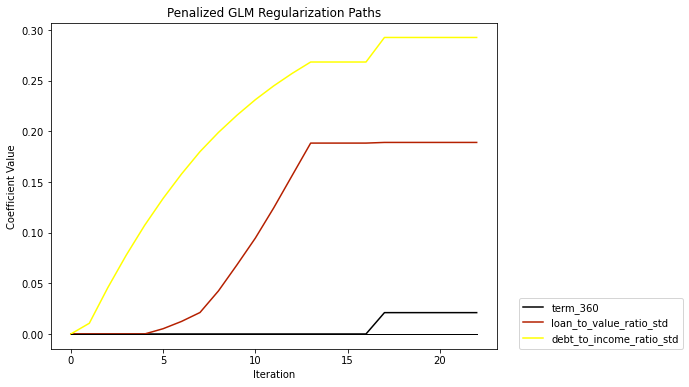

In [40]:
##Plot penalized GLM coefficient regularization path
# collect regularization paths from dict in DataFrame
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)

glm_selected = list(reg_path_frame.iloc[-1, :][reg_path_frame.iloc[-1, :] > GLM_SELECTION_THRESHOLD].index)

# plot regularization paths
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = reg_path_frame[glm_selected].plot(kind='line', ax=ax_, title='Penalized GLM Regularization Paths',
                                      colormap='gnuplot')
_ = ax_.set_xlabel('Iteration')
_ = ax_.set_ylabel('Coefficient Value')
_ = ax_.axhline(c='k', lw=1, xmin=0.045, xmax=0.955)
_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)


In [ ]:
#Compare Global Model Weights Against Alternative Model

In [41]:
"""
# collect Pearson correlation and GLM coefficients into same DataFrame
glm_selected_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])
zcorr_glm = pd.concat([corr, glm_selected_coef.iloc[1:]], axis=1)

# plot
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = corr_glm.plot(kind='barh', ax=ax_, colormap='gnuplot')
"""

"\n# collect Pearson correlation and GLM coefficients into same DataFrame\nglm_selected_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])\nzcorr_glm = pd.concat([corr, glm_selected_coef.iloc[1:]], axis=1)\n\n# plot\nfig, ax_ = plt.subplots(figsize=(8, 6))\n_ = corr_glm.plot(kind='barh', ax=ax_, colormap='gnuplot')\n"

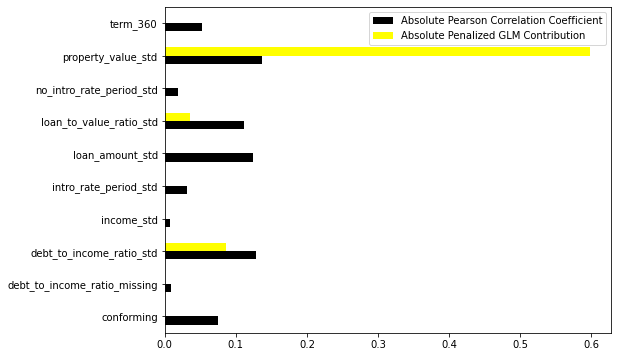

In [48]:
# define what We need for grapping
glm_contrib_frame = pd.concat([valid[x_names].abs().mean(axis=0), 
                               pd.DataFrame.from_dict(best_glm.coef(), orient='index', 
                                                      columns=['Penalized GLM Coefficient']).drop('Intercept')],
                              axis=1, sort=True)
glm_contrib_frame['Penalized GLM Contribution'] = glm_contrib_frame.iloc[:, 1] * glm_contrib_frame.iloc[:, 1]
corr_glm = pd.concat([corr.abs(), glm_contrib_frame.iloc[:, 2]], axis=1, sort=True)
corr_glm.columns = ['Absolute ' + name for name in corr_glm.columns]


# plot
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = corr_glm.plot(kind='barh', ax=ax_, colormap='gnuplot')


In [54]:
glm_pd_ice_dict = {}
for xs in glm_selected: 
    glm_pd_ice_dict[xs] = (xs, valid, best_glm)

In [64]:
##Find some percentiles in validation data
glm_percentile_dict = get_percentile_dict('phat', best_glm_phat, 'row_id')
for key in sorted(best_glm_percentiles.keys()):
    print(str(key) + ': ' + str(best_glm_percentiles[key]))

0: 95396
10: 45655
20: 44085
30: 123960
40: 109321
50: 141985
60: 99196
70: 51295
80: 159816
90: 83976
99: 109324


In [71]:
##Local Model Weights
local_coef_dict = {10: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                   50: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                   90: pd.DataFrame(columns = ['GLM Contribution'], index=x_names)}

In [68]:
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # local contributions = beta_j * x_i,j
        local_coef_dict[percentile].loc[name, 'GLM Contribution'] =\
            best_glm.coef()[name] *\
            valid[valid['row_id'] == int(glm_percentile_dict[percentile])][name].values[0]

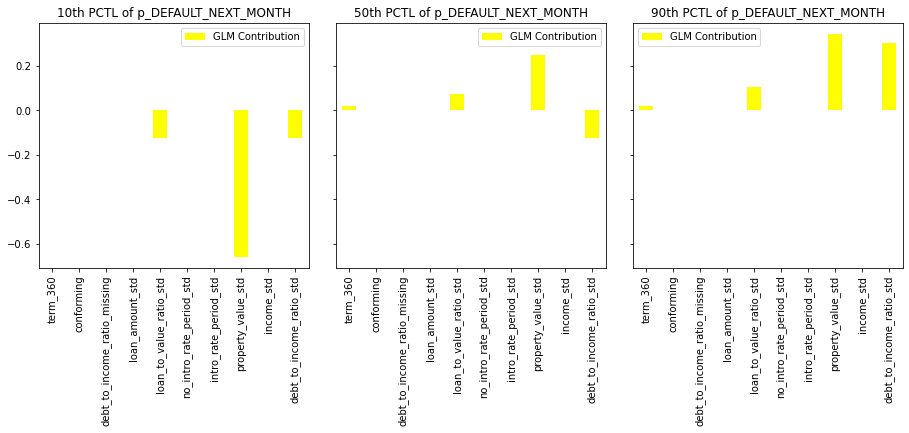

In [69]:
##Plot best GLM local contributions
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

_ = local_coef_dict[10].plot(kind='bar', color='#ffff00', ax=ax0,
                             title='10th PCTL of p_DEFAULT_NEXT_MONTH')

_ = local_coef_dict[50].plot(kind='bar', color='#ffff00', ax=ax1,
                             title='50th PCTL of p_DEFAULT_NEXT_MONTH')

_ = local_coef_dict[90].plot(kind='bar', color='#ffff00', ax=ax2,
                             title='90th PCTL of p_DEFAULT_NEXT_MONTH')

In [ ]:
#Collect global feature importance info

In [72]:
# use coefficients as relative global feature importance
global_fi = pd.DataFrame.from_dict(best_glm.coef(), columns=['GLM Importance'], orient='index')
global_fi.drop('Intercept', inplace=True)
global_fi['GLM Importance'] = np.abs(global_fi['GLM Importance'])

In [ ]:
#Select percentiles from predictions

In [ ]:
##Analyze feature importance
#Compare global feature importance across models

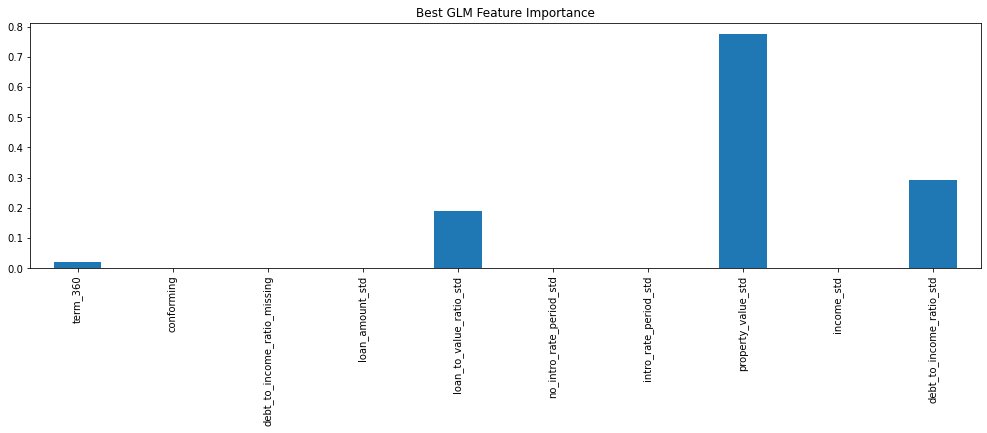

In [77]:
fig, (ax0) = plt.subplots(ncols=1)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

_ = global_fi['GLM Importance'].plot(kind='bar', ax=ax0, title='Best GLM Feature Importance')

In [ ]:
#Compare local feature importance across models

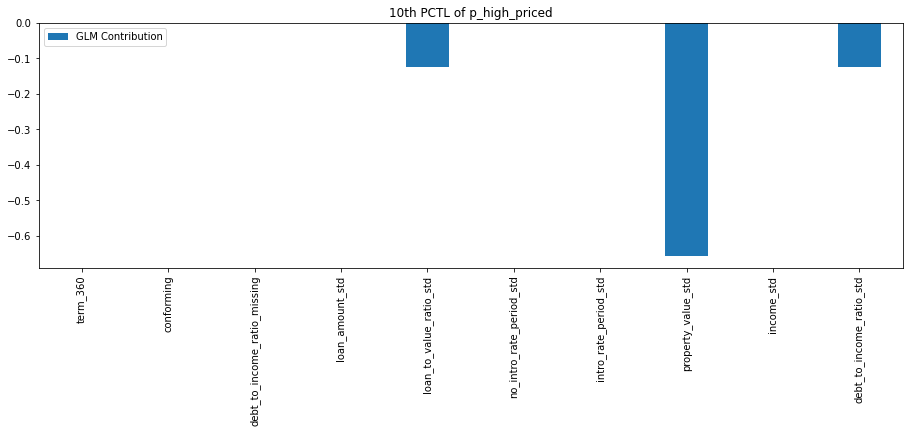

In [78]:
## init 3-pane plot 
fig, (ax0) = plt.subplots(ncols=1, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0,
                             title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar', ax=ax1,
                             title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar', ax=ax2,
                             title='90th PCTL of p_high_priced')

In [ ]:
#Utility function for partial dependence